# WATER BAG CLASSIFICATION - IMBALANCE AND CALIBRATION
### BASED ON INMET METHEOROLOGICAL STATIONS DATA

---
## Define Functions

#### Change project root directory

In [ ]:
cd ../

#### Import modules and libraries

In [8]:
import os, json, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time serie features transformation pipeline & binary classification pipeline (Authoral)
from Modulos.sample_filter import min_max_filter_stats, min_max_filter
from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample
from Modulos.imbalanced_classification import ClassificationPipeline, classesGroupRecall

#### Preprocessing & machine learning modules
from sklearn.preprocessing import MinMaxScaler as mms
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt
from sklearn.utils import all_estimators
from sklearn.metrics import classification_report as cr
from imblearn import ensemble

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

# Select specific classification models
gbc = classifiers['GradientBoostingClassifier']
brfc = ensemble.BalancedRandomForestClassifier

#### Define metrics and scoring functions
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score

recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall', 'precision': 'precision',
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1
}

### Utility functions

In [9]:
from imblearn.under_sampling import RandomUnderSampler

def balanced_filtered_test_cv(X, Y, X_filt, cv_filt, seed=None, test_prct='natural'):

    X_index = np.array(range(X.shape[0]))
    out_index = X_index[~X.index.isin(X_filt.index)].tolist() # filtered out records index, only contains negative class samples

    if test_prct == 'Y':
        y_cnt = Y.value_counts(); test_prct = y_cnt[1] / y_cnt[0]
    rus = RandomUnderSampler(test_prct, random_state=seed)

    # Reuse group shuffle and include left out negative class test samples 
    cv_plus = []
    for t_idx, e_idx in cv_filt:
        t_idx_x,  e_idx_x = (X_index[X.index.isin(X_filt.iloc[idx].index)].tolist() for idx in [t_idx, e_idx]) # Convert X_filt positional index to X positional index
        left_test = e_idx_x + out_index
        x_test, y_test = Xf.iloc[left_test], Y.iloc[left_test]
        x_under, y_under = rus.fit_resample(x_test, y_test)
        y_under.index = y_test.index[rus.sample_indices_]
        left_under = X_index[X.index.isin(y_under.index)].tolist()
        cv_plus.append((t_idx_x, left_under)) 
    print_cls_cnt(Y, cv_plus[0][0], cv_plus[0][1])
    return cv_plus

---
## Load & Preprocess Data

In [10]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True)

data = project.data
group_ts = project.time_serie
waterbags = project.waterbags

# Drop records before july, 2018 to reduce imbalance
# data = data['2018-06':]
# group_ts = group_ts['2018-06':]

# Sample groups names per group label
routes = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

---

# Preprocessing and Data Transformation

### Feature dataset and target variables

In [14]:
top_grp = '1'

min_time = '2018-06'

X = TimeseriesTransformPipeline(
    data, min_time, cut=-1,
    drop_empty_cols=True, scale=True,
    interpolate=None, fillna=None
)

Xf = TimeseriesTransformPipeline(
    X, interpolate='nearest', fillna='min'
)

### Select example water bag group
Y = group_ts[str(top_grp)].loc[X.index].copy()

groups = groupConsecutiveFlags(ts=Y)

cnts = [Y.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print(f'Water bag group: {routes[int(top_grp)]}. (id: {top_grp})')
print(); display(pd.concat(cnts, 1))

Initial data: (437875, 230)
Time extraction: (142866, 230)
Drop empty columns:  (142865, 217)
Initial data: (142865, 217)
Water bag group: Rua do Catete. (id: 1)



,Class Count,Class Count
0.0,142082,0.994519
1.0,783,0.005481


### Target Transformation

In [15]:
periods_ahead = 4 # Periods in the future to predict

Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(- periods_ahead + 1) > 0).astype('float')
groups = groupConsecutiveFlags(ts=Y)

cnts = [Y.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print('Y shape:', Y.shape, '\n')
print('Train folder'); display(pd.concat(cnts, 1))

Y shape: (142865,) 

Train folder


,Class Count,Class Count
0.0,141868,0.993021
1.0,997,0.006979


### Validation folder

In [16]:
train_end, eval_start, eval_end = '2021-10', '2021-11', '2022-04'

# Validataion fraction
X_eval = Xf[eval_start: eval_end]
X = X[:train_end]
Xf = Xf[:train_end]

Y_eval = Y.loc[X_eval.index]
Y = Y.loc[X.index]

groups_eval = groups.loc[X_eval.index]
groups = groups.loc[X.index]

cnts = [Y.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print('Train folder'); display(pd.concat(cnts, 1))

cnts = [Y_eval.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print('Validation folder'); display(pd.concat(cnts, 1))

Train folder


,Class Count,Class Count
0.0,119037,0.992777
1.0,866,0.007223


Validation folder


,Class Count,Class Count
0.0,17245,0.992461
1.0,131,0.007539


### Validation statistics

In [17]:
eval_size = len(Y_eval) / len(Y) * 100
eval_minority = (Y_eval==1).sum() / (Y==1).sum() * 100
eval_stats = pd.DataFrame(
    [eval_size, eval_minority],
    ['Samples', 'Positive Samples'],
    ['Validation (%)'],
).round(2)
display(eval_stats)

,Validation (%)
Samples,14.49
Positive Samples,15.13


### Data leaking

In [23]:
Y.head(3).index

DatetimeIndex(['2018-06-01 00:15:00', '2018-06-01 00:30:00',
               '2018-06-01 00:45:00'],
              dtype='datetime64[ns]', freq=None)

In [18]:
Y.tail(3).index # Train end

DatetimeIndex(['2021-10-31 23:15:00', '2021-10-31 23:30:00',
               '2021-10-31 23:45:00'],
              dtype='datetime64[ns]', freq=None)

In [19]:
Y_eval.head(3).index # Validation start

DatetimeIndex(['2021-11-01 00:00:00', '2021-11-01 00:15:00',
               '2021-11-01 00:30:00'],
              dtype='datetime64[ns]', freq=None)

---
# Filter hour records

### Records left after filtering by columns' minimum thresholds

In [24]:
#### Extract minority and majority classes records
mino, majo = X[Y==1], X[~(Y==1)]
mino_desc = mino.describe()

#### Filter records by minority minimum values
stats, cum_stats = min_max_filter_stats(X, mino_desc, stat='min', acumulate='and', top_down=True)
stats_max, cum_stats_max = min_max_filter_stats(X, mino_desc, stat='max', acumulate='and', top_down=True)

#### Records above and below target minimum and maximum per column

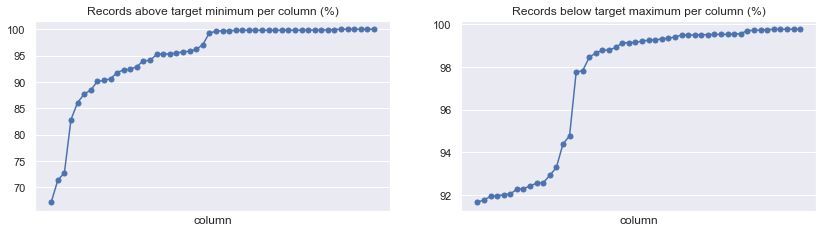

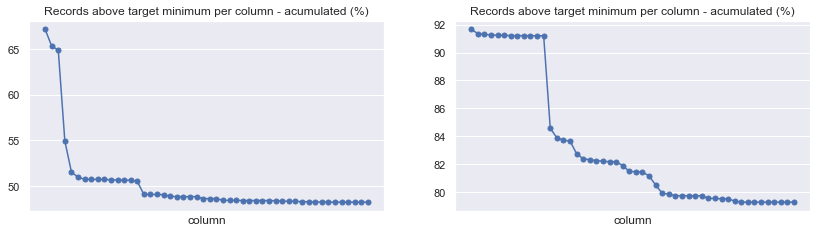

In [25]:
n_cum = 50

fig, ax = plt.subplots(1, 2, figsize=(14, 3.5))
stats.set_index('column')['rows left (%)'].head(n_cum).plot(marker='o', ms=5, xticks=[], title='Records above target minimum per column (%)', ax=ax[0])
stats_max.set_index('column')['rows left (%)'].head(n_cum).plot(marker='o', ms=5, xticks=[], title='Records below target maximum per column (%)', ax=ax[1])

fig, ax = plt.subplots(1, 2, figsize=(14, 3.5))
cum_stats.set_index('column')['rows left cum (%)'].iloc[:n_cum].plot(xticks=[], marker='o', ms=5, title='Records above target minimum per column - acumulated (%)', ax=ax[0])
cum_stats_max.set_index('column')['rows left cum (%)'].iloc[:n_cum].plot(xticks=[], marker='o', ms=5, title='Records above target minimum per column - acumulated (%)', ax=ax[1])
plt.show()

### Filter records

In [34]:
n_filters_min, n_filters_max = 5, 13

min_values = mino_desc.loc['min'].loc[stats['column']]
max_values = mino_desc.loc['max'].loc[stats_max['column']]

# Filter data by positive class minimum values
X_filt = min_max_filter(
    X, min_values, # max_values,
    n_filters=n_filters_min, margin_min=0.0, margin_max=0.0
)

# Filter data by positive class maximum values
X_filt = min_max_filter(
    X_filt, None, max_values,
    n_filters=n_filters_max, margin_min=0.0, margin_max=0.0
)

### Filtered transformed data
X_filt = Xf.loc[X_filt.index]
# X_filt = TimeseriesTransformPipeline(
#     X_filt, interpolate='nearest', fillna='min'
# )

### Filter target variable
Y_filt = Y.loc[X_filt.index]

# groups_filt = groupConsecutiveFlags(ts=Y_filt)
groups_filt = groups.loc[X_filt.index] # Does the same as above

cnts = [
    Y_filt.value_counts().to_frame('Class Count'),
    100 * (Y_filt.value_counts().to_frame('Percent left (%)') / Y.value_counts().to_frame('Percent left (%)')).round(4)
]
display(pd.concat(cnts, 1))


Records: 119903
Records left: 61796
Records left (%): 51.54 %


Records: 61796
Records left: 54492
Records left (%): 88.18 %



,Class Count,Percent left (%)
0.0,53626,45.05
1.0,866,100.00


---
# KFold Group Splits

In [47]:
# Main parameters definition
seed = 0

n_splits = 5
train_size = 0.799
test_size = 0.2
train_prct = None
test_prct = 'natural'

# Model definition
model = gbc(n_estimators=100, random_state=seed)

### Base line KFold - Natural

In [36]:
splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    train_prct=None, test_prct='natural',
    random_state=seed
)

cv_base = list(splitter.split(
    Xf, Y, groups,
    strategy='GroupKFold'
)); print_cls_cnt(Y, cv_base[0][0], cv_base[0][1])

,Train set,Test set
Class,,
0.0,95119,23917
1.0,692,174


### Base line Shuffle - Undersample

In [48]:
splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    train_prct=1, test_prct='natural',
    random_state=seed,
)

cv_under = list(splitter.split(
    Xf, Y, groups,
    strategy='GroupKFold'
)); print_cls_cnt(Y, cv_under[0][0], cv_under[0][1])

,Train set,Test set
Class,,
0.0,692,23917
1.0,692,174


### Filtered KFold - Natural

In [49]:
splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    train_prct=None, test_prct=None,
    random_state=seed,
)

cv_filt = list(splitter.split(
    X_filt, Y_filt, groups_filt,
    strategy='GroupKFold'
))

cv_filt = balanced_filtered_test_cv(X, Y, X_filt, cv_filt, seed, test_prct='Y')

c:\Users\luisr\anaconda3\lib\site-packages\imblearn\utils\_validation.py:587: FutureWarning: Pass sampling_strategy=0.007275048934364946 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


,Train set,Test set
Class,,
0.0,42851,23917
1.0,692,174


### Filtered KFold - Undersample

In [50]:
splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    train_prct=1, test_prct=None,
    random_state=seed,
)

cv_filt_under = list(splitter.split(
    X_filt, Y_filt, groups_filt,
    strategy='GroupKFold'
))

cv_filt_under = balanced_filtered_test_cv(X, Y, X_filt, cv_filt_under, seed, test_prct='Y')

c:\Users\luisr\anaconda3\lib\site-packages\imblearn\utils\_validation.py:587: FutureWarning: Pass sampling_strategy=0.007275048934364946 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


,Train set,Test set
Class,,
0.0,692,23917
1.0,692,174


### Baseline adjusted udnersample

In [51]:
filt_prop = (Y_filt == 1).mean()
filt_prct = 1 / filt_prop - 1

splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    train_prct=filt_prct, test_prct='natural',
    random_state=seed,
)

cv_adjust = list(splitter.split(
    Xf, Y, groups,
    strategy='GroupKFold'
)); print_cls_cnt(Y, cv_adjust[0][0], cv_adjust[0][1])

,Train set,Test set
Class,,
0.0,42851,23917
1.0,692,174


---
# Cross validate filtered records

In [52]:
scr_cols = ['mean', 'std'], ['test_recall-1', 'test_precision-1']

### Baseline KFold

In [20]:
scr_base = pd.DataFrame(cross_validate(
    model, Xf, Y, cv=cv_base,
    scoring=scoring, n_jobs=-1,
    verbose=5, error_score='raise'
))

#### Save and reload baseline score
# scr_base.to_csv('Modelagem de Bolsões/Scores/Baseline_1h_KFold_5.csv', index=True)
# scr_base = pd.read_csv('Modelagem de Bolsões/Scores/Baseline_1h_KFold_5.csv', index_col=0)

scr_base.describe().loc[(scr_cols)]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.0min remaining: 12.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.1min finished


,test_recall-1,test_precision-1
mean,0.125700,0.455927
std,0.094999,0.245799


### Baseline undersample

In [42]:
scr_under = pd.DataFrame(cross_validate(
    model, Xf, Y, cv=cv_under,
    scoring=scoring, n_jobs=-1,
    verbose=5, error_score='raise'
))

#### Save and reload score
# scr_under.to_csv('Modelagem de Bolsões/Scores/Under_1h_KFold_5.csv', index=True)
# scr_under = pd.read_csv('Modelagem de Bolsões/Scores/Under_1h_KFold_5.csv', index_col=0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [57]:
scr_under.describe().loc[(scr_cols)]

,test_recall-1,test_precision-1
mean,0.942256,0.146100
std,0.033718,0.006035


### Filtered natural

In [45]:
scr_filt = pd.DataFrame(cross_validate(
    model,
    Xf, Y,
    cv=cv_filt, scoring=scoring,
    return_train_score=True,
    n_jobs=-1, verbose=5,
))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.4min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


In [36]:
scr_filt.describe().loc[(scr_cols)]

,test_recall-1,test_precision-1
mean,0.077614,0.038129
std,0.108325,0.057044


### Filtered undersample

In [34]:
scr_filt_under = pd.DataFrame(cross_validate(
    model, Xf, Y, cv=cv_filt_under,
    scoring=scoring, n_jobs=-1,
    verbose=5, error_score='raise'
))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


In [37]:
scr_filt_under.describe().loc[(scr_cols)]

,test_recall-1,test_precision-1
mean,0.364209,0.005687
std,0.129279,0.001752


### Baseline adjusted udnersample

In [35]:
scr_adjust = pd.DataFrame(cross_validate(
    model, Xf, Y, cv=cv_adjust,
    scoring=scoring, n_jobs=-1,
    verbose=5, error_score='raise'
))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   35.9s remaining:   53.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   59.2s finished


In [38]:
scr_adjust.describe().loc[(scr_cols)]

,test_recall-1,test_precision-1
mean,0.154538,0.236775
std,0.110080,0.136320


### Filtered sample train + natural proportion test - Fill test predictions

In [20]:
scrs = []
for i, (t_ind, e_ind) in enumerate(cv_plus):
    co(wait=True); print(f'{i+1}/{len(cv_plus)} splits scored')
    xt, xe, yt, ye = Xf.iloc[t_ind], Xf.iloc[e_ind], Y.iloc[t_ind], Y.iloc[e_ind]
    model.fit(xt, yt)
    yhat = model.predict(xe)
    # Fill prediction of outsider group 
    filt_out = pd.Series(e_ind, dtype='int').isin(out_index).values
    yhat[filt_out] = 0.0  # Fix prediction for data left out of the filter
    scr = pd.DataFrame(cr(ye, yhat, output_dict=True)).T
    scr = pd.concat([scr.loc[['0.0', '1.0', 'macro avg'], 'recall'], scr.loc[['0.0', '1.0', 'macro avg'], 'precision']])
    scr.index = ['recall 0', 'recall 1', 'recall', 'precision 0', 'precision 1',  'precision']
    scrs.append(scr)
scr_fill = pd.concat(scrs, 1).T

5/5 splits scored


---
# Visualize cross validation results

### Score statistical description comparison

In [21]:
desc_base = group_shuffle_scr.describe().loc[['mean', 'min', 'max', 'std'], ['test_recall-0', 'test_recall-1', 'test_precision-1']]
desc_filt = scr_filt.describe().loc[['mean', 'min', 'max', 'std'], ['test_recall-0', 'test_recall-1', 'test_precision-1']]
desc_out = scr_out.describe().loc[['mean', 'min', 'max', 'std'], ['test_recall-0', 'test_recall-1', 'test_precision-1']]
desc_fill = scr_fill.describe().loc[['mean', 'min', 'max', 'std'], ['recall 0', 'recall 1', 'precision 1']]

titles = [
    'Base line - true proportion',
    'Filtered - internal proportion',
    'Filtered - true proportion',
    'Filtered fixed predictions - true proportion'
]

descs = [desc_base, desc_filt, desc_out, desc_fill]

for title, desc in zip(titles, descs):
    print('\n', title, '\n')
    display(pd.concat([desc]))


 Base line - true proportion 



,test_recall-0,test_recall-1,test_precision-1
mean,0.999666,0.232143,0.684211
min,0.999666,0.232143,0.684211
max,0.999666,0.232143,0.684211
std,NaN,NaN,NaN



 Filtered - internal proportion 



,test_recall-0,test_recall-1,test_precision-1
mean,0.997553,0.212072,0.684146
min,0.995722,0.120000,0.580645
max,0.998684,0.283784,0.777778
std,0.001102,0.064946,0.074158



 Filtered - true proportion 



,test_recall-0,test_recall-1,test_precision-1
mean,0.778707,0.217405,0.081988
min,0.436049,0.146667,0.001326
max,0.999085,0.283784,0.371429
std,0.253066,0.055970,0.162178



 Filtered fixed predictions - true proportion 



,recall 0,recall 1,precision 1
mean,0.999950,0.217405,0.936623
min,0.999916,0.146667,0.900000
max,1.000000,0.283784,1.000000
std,0.000035,0.055970,0.042087


### Score distribution comparison for baseline vs predicted vs filled excluded samples

c:\Users\luisr\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\luisr\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\luisr\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\luisr\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


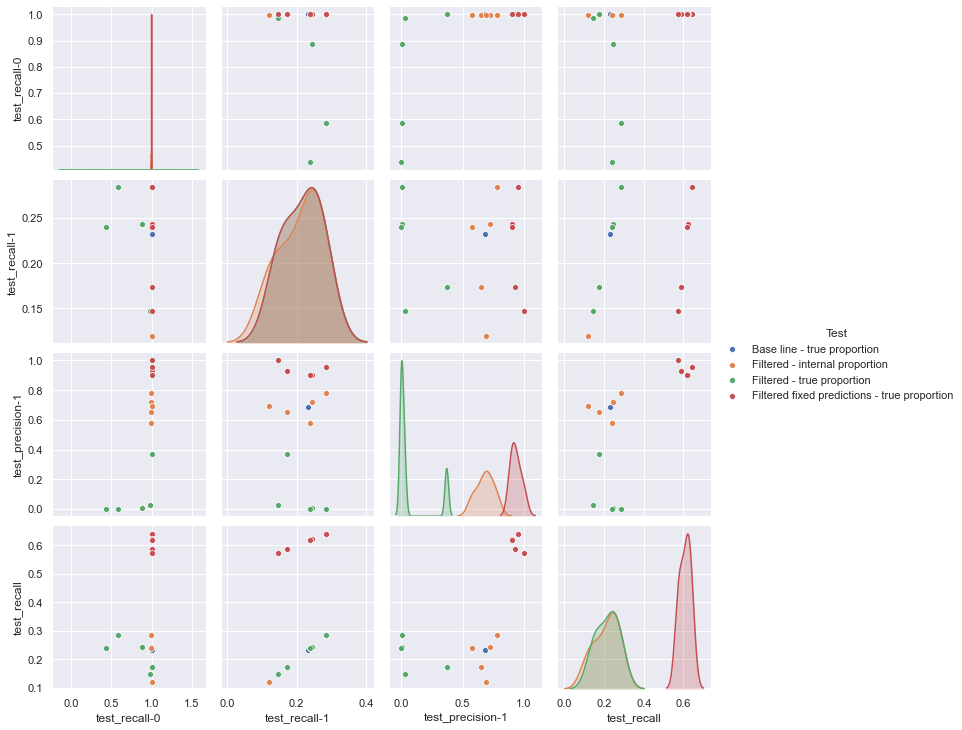

In [22]:
scr_fill_fmt = scr_fill.rename(columns={
    'recall 0': 'test_recall-0',
    'recall 1': 'test_recall-1',
    'precision 1': 'test_precision-1',
    'recall': 'test_recall'
})

titles = [
    'Base line - natural',
    'Base line - Undersample',
    'Filtered - Natural',
    'Filtered - Undersample',
    'Base line - Adjusted',
]

scrs = [
    group_shuffle_scr,
    scr_filt,
    scr_out,
    scr_fill_fmt,
]

for i, score in enumerate(scrs):
    scrs[i]['Test'] = titles[i]

tests = pd.concat(scrs, join='inner')[['test_recall-0', 'test_recall-1', 'test_precision-1', 'test_recall', 'Test']]

ax = sns.pairplot(tests, hue='Test')

---
# Final Model Evaluation

### Select best split

In [23]:
scr_filt.sort_values('test_recall', ascending=False)[['test_recall-1', 'test_precision-1']]

,test_recall-1,test_precision-1
1,0.283784,0.777778
2,0.243243,0.720000
4,0.240000,0.580645
0,0.173333,0.650000
3,0.120000,0.692308


In [24]:
selected_split = 3
split = cv_filt[selected_split]

### Optional: Shuffle split

### Filter internal train test samples

In [25]:
t_ind, e_ind = split[0], split[1]
print_cls_cnt(Y_filt, t_ind, e_ind)

xt, xe = X_filt.iloc[t_ind], X_filt.iloc[e_ind]
yt, ye = Y_filt.iloc[t_ind], Y_filt.iloc[e_ind]

,Train set,Test set
Class,,
0.0,12072,3039
1.0,298,75


### Filtered train vs rest sample

In [26]:
train_index = yt.index
test_index = Y.drop(yt.index).index
print_cls_cnt(Y, train_index, test_index)

x_rest, y_rest = Xf.loc[test_index], Y.loc[test_index]

,Train set,Test set
Class,,
0.0,12072,107458
1.0,298,75


### True proportion test sample

In [27]:
from imblearn.under_sampling import RandomUnderSampler

y_cnt = Y.value_counts()
rus = RandomUnderSampler(sampling_strategy=y_cnt[1]/y_cnt[0], random_state=seed)

x_true, y_true = rus.fit_resample(x_rest, y_rest) # resample full test data to true proportion
y_true.index = y_rest.iloc[rus.sample_indices_].index
x_true.index = y_true.index

display(y_true.value_counts().to_frame('Test size - true proportion'))

,Test size - true proportion
0.0,24034
1.0,75


### Sample leaking

In [28]:
train_index.isin(ye.index).sum()

0

In [29]:
train_index.isin(test_index).sum()

0

In [30]:
train_index.isin(x_true.index).sum()

0

In [31]:
train_index.isin(X_eval.index).sum()

0

### Fit model to train data

In [32]:
model = gbc(n_estimators=100, random_state=seed, verbose=1)

model.fit(xt, yt)

      Iter       Train Loss   Remaining Time 
         1           0.1661           30.61s
         2           0.1460           29.81s
         3           0.1351           29.47s
         4           0.1259           28.80s
         5           0.1161           28.46s
         6           0.1092           28.23s
         7           0.1043           27.77s
         8           0.0968           28.07s
         9           0.0921           27.96s
        10           0.0885           27.76s
        20           0.0631           24.89s
        30           0.0456           21.80s
        40           0.0378           18.66s
        50           0.0328           15.63s
        60           0.0298           12.45s
        70           0.0273            9.34s
        80           0.0234            6.30s
        90           0.0220            3.17s
       100           0.0204            0.00s


GradientBoostingClassifier(random_state=0, verbose=1)

### Split internal proportion test set score

In [33]:
yhat = model.predict(xe)
CR = pd.DataFrame(cr(ye, yhat, digits=4, output_dict=True)).T
display(CR.loc[['0.0', '1.0']])

,precision,recall,f1-score,support
0.0,0.978717,0.998684,0.988599,3039.0
1.0,0.692308,0.120000,0.204545,75.0


### True proportion test set score

In [34]:
yhat_true = model.predict(x_true)
CR = pd.DataFrame(cr(y_true, yhat_true, digits=4, output_dict=True)).T
display(CR.loc[['0.0', '1.0']])

,precision,recall,f1-score,support
0.0,0.997127,0.952983,0.974555,24034.0
1.0,0.007902,0.120000,0.014827,75.0


Obs: Test negative sample size is increased but negative precision increases anyway, against what's expected.

### Validation set score

In [35]:
yhat_eval = model.predict(X_eval)
scr = pd.DataFrame(cr(Y_eval, yhat_eval, output_dict=True)).T
display(scr.loc[['0.0', '1.0']])

,precision,recall,f1-score,support
0.0,0.999307,0.915465,0.955550,17330.0
1.0,0.023333,0.760870,0.045278,46.0


### Filled validation set score

In [36]:
# Filter data by positive class minimum values
X_eval_filt = min_max_filter(
    X_eval, min_values, # max_values,
    n_filters=n_filters, margin_min=0.0, margin_max=0.0
)

filt_out = ~ Y_eval.index.isin(X_eval_filt.index)

yhat_fill = yhat_eval.copy()
yhat_fill[filt_out] = 0.0  # Fix prediction for data left out of the filter

scr = pd.DataFrame(cr(Y_eval, yhat_fill, output_dict=True)).T
display(scr.loc[['0.0', '1.0']])

NameError: name 'n_filters' is not defined